<a href="https://colab.research.google.com/github/nishatmncse/ML_HW2/blob/main/HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip -q install openpyxl

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

import matplotlib.pyplot as plt


In [17]:
from google.colab import files
uploaded = files.upload()

file_name = list(uploaded.keys())[0]
print("Uploaded file:", file_name)


Saving weatherAUS.csv to weatherAUS.csv
Uploaded file: weatherAUS.csv


In [34]:
import os

if file_name.lower().endswith(".csv"):
    df = pd.read_csv(file_name, encoding="latin1")
elif file_name.lower().endswith(".xlsx"):
    df = pd.read_excel(file_name, engine="openpyxl")
else:
    raise ValueError("Unsupported file format")

print("Dataset loaded successfully")
print("Shape:", df.shape)


# Drop Date column (as instructed)
df = df.drop(columns=["Date"], errors="ignore")

# Drop rows with missing target
df = df.dropna(subset=["RainTomorrow"])

# Features and target
X = df.drop(columns=["RainTomorrow"])
y = df["RainTomorrow"]

# 90% train / 10% test (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.10, random_state=42, stratify=y
)

# Save train/test datasets to /content
train_df = X_train.copy()
train_df["RainTomorrow"] = y_train

test_df = X_test.copy()
test_df["RainTomorrow"] = y_test

train_path = "/content/weather_train.csv"
test_path  = "/content/weather_test.csv"

train_df.to_csv(train_path, index=False)
test_df.to_csv(test_path, index=False)

print("Saved:", train_path, " shape:", train_df.shape)
print("Saved:", test_path,  " shape:", test_df.shape)

print("Train class distribution:\n", y_train.value_counts(normalize=True))
print("Test class distribution:\n", y_test.value_counts(normalize=True))



Dataset loaded successfully
Shape: (145460, 23)
Saved: /content/weather_train.csv  shape: (127973, 22)
Saved: /content/weather_test.csv  shape: (14220, 22)
Train class distribution:
 RainTomorrow
No     0.77582
Yes    0.22418
Name: proportion, dtype: float64
Test class distribution:
 RainTomorrow
No     0.775809
Yes    0.224191
Name: proportion, dtype: float64


In [35]:
# Detect categorical and numeric columns
categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
numerical_cols   = X_train.select_dtypes(exclude=["object"]).columns.tolist()

# Numeric: impute median + scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical: impute most frequent + one-hot
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)



In [36]:
# Model focused on ACCURACY (no class balancing)
base_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

param_grid = {
    "classifier__C": [0.01, 0.1, 1, 10, 50]
}

grid = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("Test Accuracy:", round(acc, 4))
print(classification_report(y_test, y_pred))


Test Accuracy: 0.8475
              precision    recall  f1-score   support

          No       0.87      0.95      0.91     11032
         Yes       0.73      0.51      0.60      3188

    accuracy                           0.85     14220
   macro avg       0.80      0.73      0.75     14220
weighted avg       0.84      0.85      0.84     14220



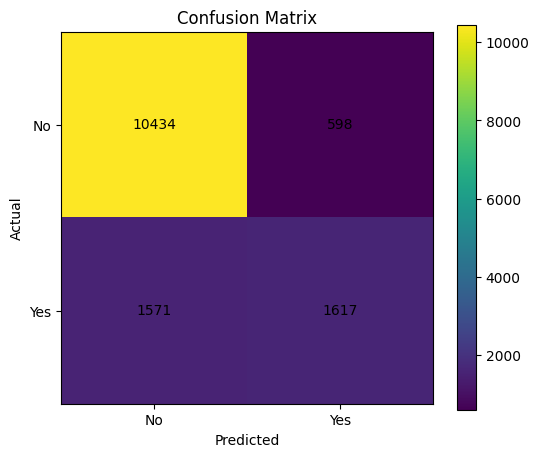

In [37]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix")
plt.colorbar()
plt.xticks([0,1], ["No", "Yes"])
plt.yticks([0,1], ["No", "Yes"])

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


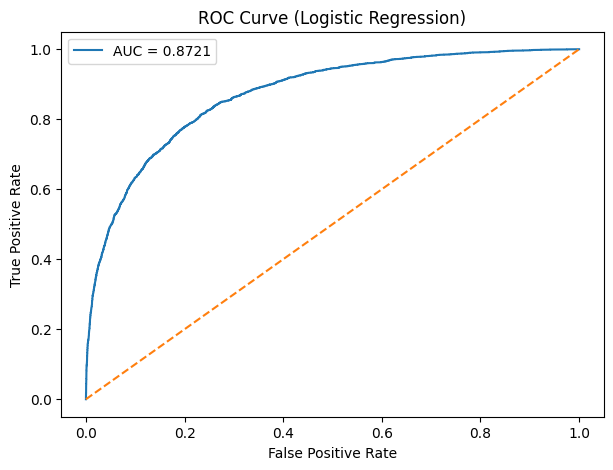

In [38]:
# Probability for "Yes" class
yes_index = list(best_model.named_steps["classifier"].classes_).index("Yes")
y_proba = best_model.predict_proba(X_test)[:, yes_index]

y_true = (y_test == "Yes").astype(int)

fpr, tpr, _ = roc_curve(y_true, y_proba)
auc = roc_auc_score(y_true, y_proba)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve (Logistic Regression)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

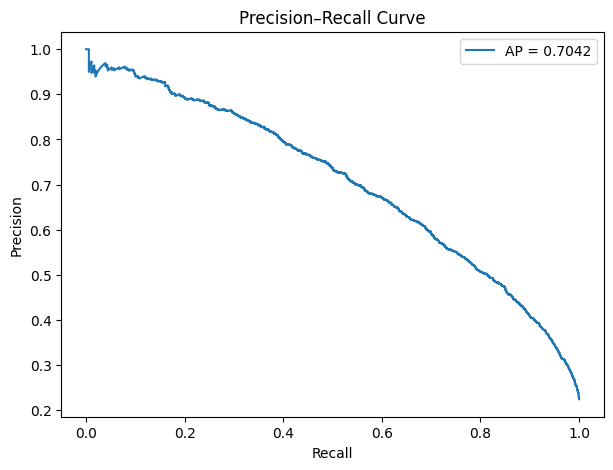

In [39]:
precision, recall, _ = precision_recall_curve(y_true, y_proba)
ap = average_precision_score(y_true, y_proba)

plt.figure(figsize=(7,5))
plt.plot(recall, precision, label=f"AP = {ap:.4f}")
plt.title("Precision–Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

In [41]:
from google.colab import files
files.download("/content/weather_train.csv")
files.download("/content/weather_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>